<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/Week_2_lab_linear_regression_with_polynomial_and_interaction_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importation and Configuration

In [1]:
# latest version of sklearn (to have access to recent features)
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 64.7 MB/s eta 0:00:00


In [2]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge

##Data and Polynomial Feature Engineering

### The Dataset

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#  load and view the first 5 rows
df = pd.read_csv('/content/drive/MyDrive/poly-interact-synth-data.csv')


In [7]:
df.head()

,x1,x2,x3,y
0,1.764052,0.555963,-1.532921,32.453903
1,0.400157,0.892474,-1.711970,14.758467
2,0.978738,-0.422315,0.046135,5.225171
3,2.240893,0.104714,-0.958374,32.687982
4,1.867558,0.228053,-0.080812,24.122815


In [8]:
# Statistical Description
df.describe()

,x1,x2,x3,y
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.045257,0.013617,-0.051229,4.510305
std,0.987527,0.968644,0.954594,12.402649
min,-3.046143,-2.994613,-3.116857,-14.027565
25%,-0.698420,-0.653850,-0.736665,-4.402095
50%,-0.058028,0.026062,-0.052498,1.811906
75%,0.606951,0.625480,0.621616,10.198600
max,2.759355,3.170975,2.929096,64.364038


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   float64
 3   y       1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


#### EDA

In [39]:
# Statistical Description
df.describe()

,x1,x2,x3,y
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.045257,0.013617,-0.051229,4.510305
std,0.987527,0.968644,0.954594,12.402649
min,-3.046143,-2.994613,-3.116857,-14.027565
25%,-0.698420,-0.653850,-0.736665,-4.402095
50%,-0.058028,0.026062,-0.052498,1.811906
75%,0.606951,0.625480,0.621616,10.198600
max,2.759355,3.170975,2.929096,64.364038


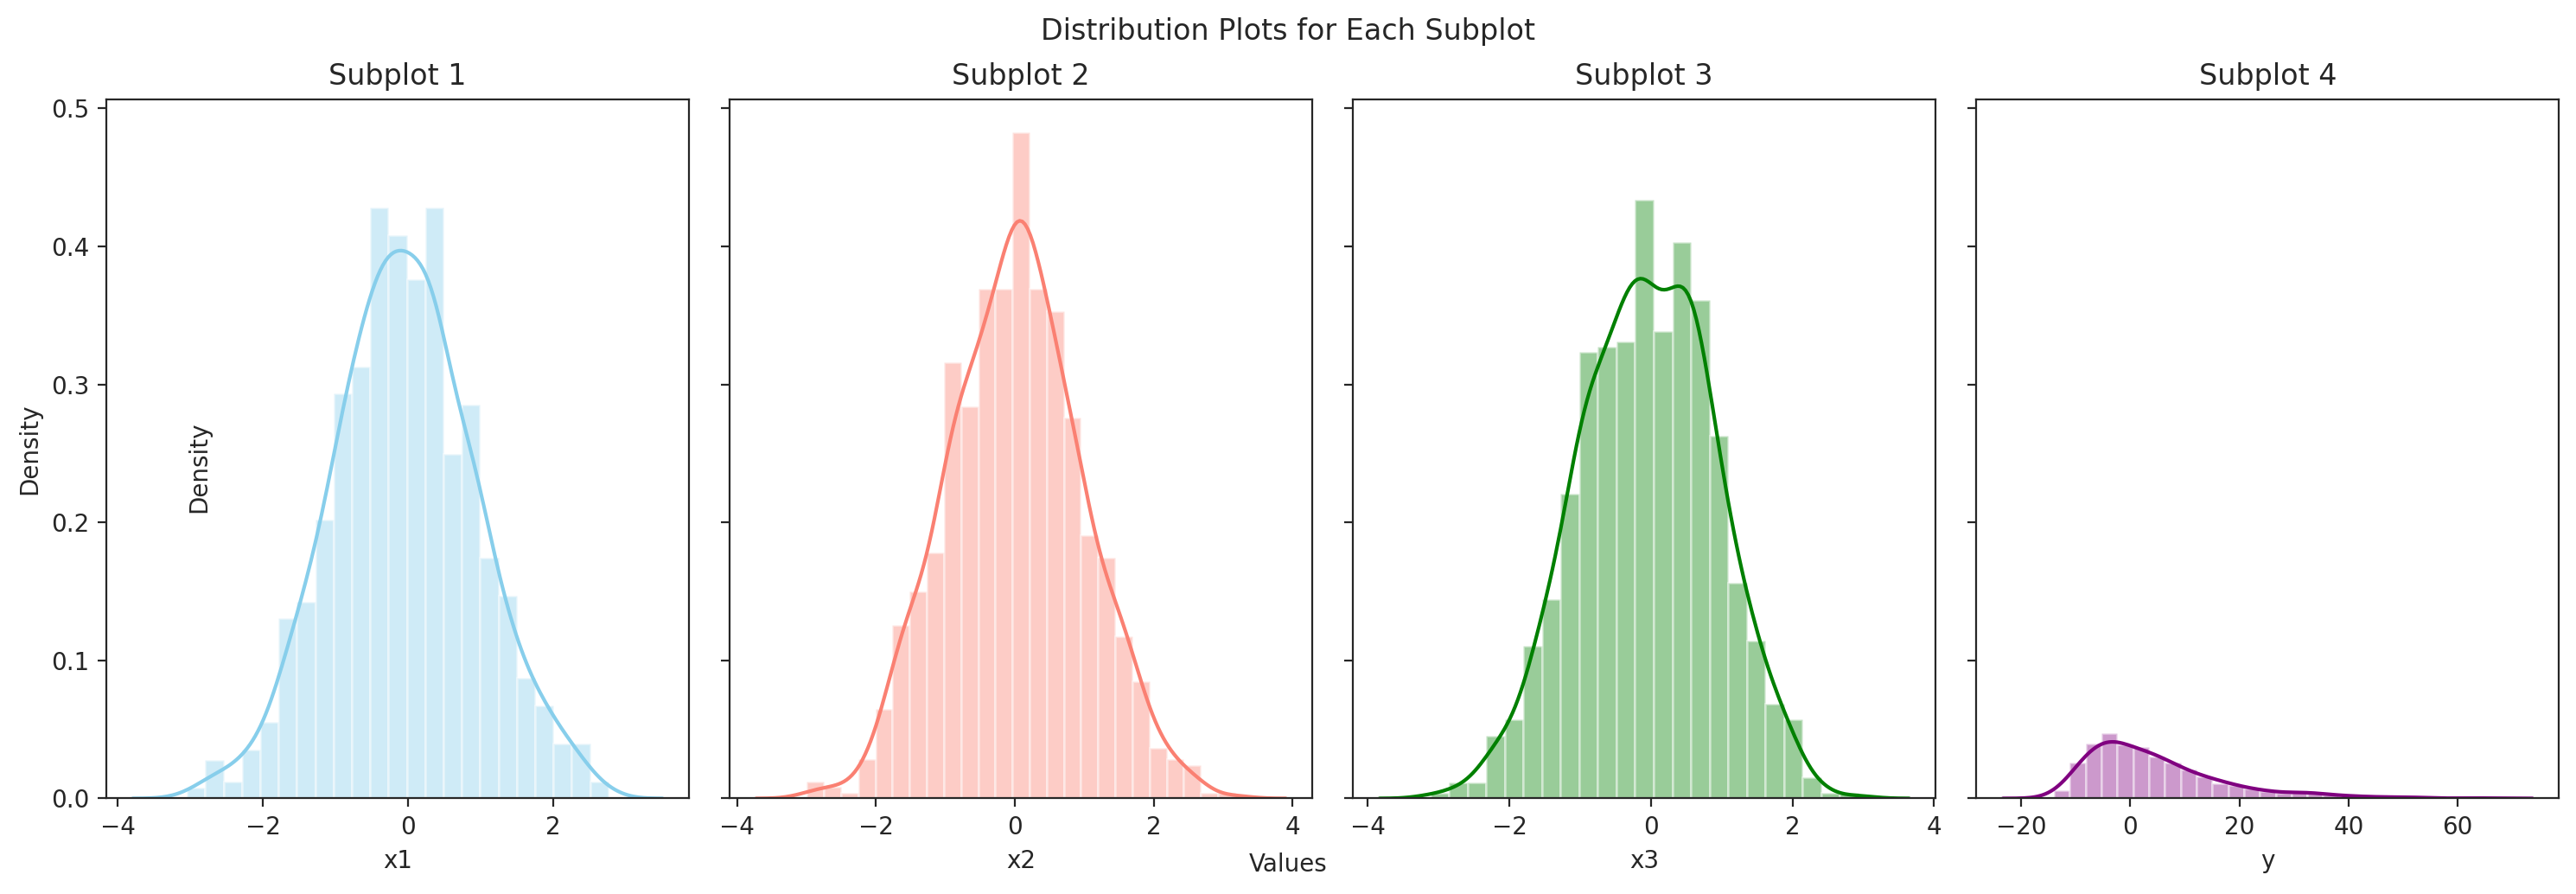

In [9]:
# visualize distribution
# Create a 1x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

# Plotting the distribution for each subplot
sns.distplot(df['x1'], kde=True, color="skyblue", ax=axes[0])
axes[0].set_title("Subplot 1")

sns.distplot(df['x2'], kde=True, color="salmon", ax=axes[1])
axes[1].set_title("Subplot 2")

sns.distplot(df['x3'], kde=True, color="green", ax=axes[2])
axes[2].set_title("Subplot 3")

sns.distplot(df['y'], kde=True, color="purple", ax=axes[3])
axes[3].set_title("Subplot 4")

# Add a common y-axis label
fig.text(0.5, 0.04, 'Values', ha='center', va='center')
fig.text(0.08, 0.5, 'Density', ha='center', va='center', rotation='vertical')

# Adjust layout to prevent clipping of y-axis labels
plt.tight_layout()

# Show the plot
plt.suptitle("Distribution Plots for Each Subplot", y=1.02)
plt.show()

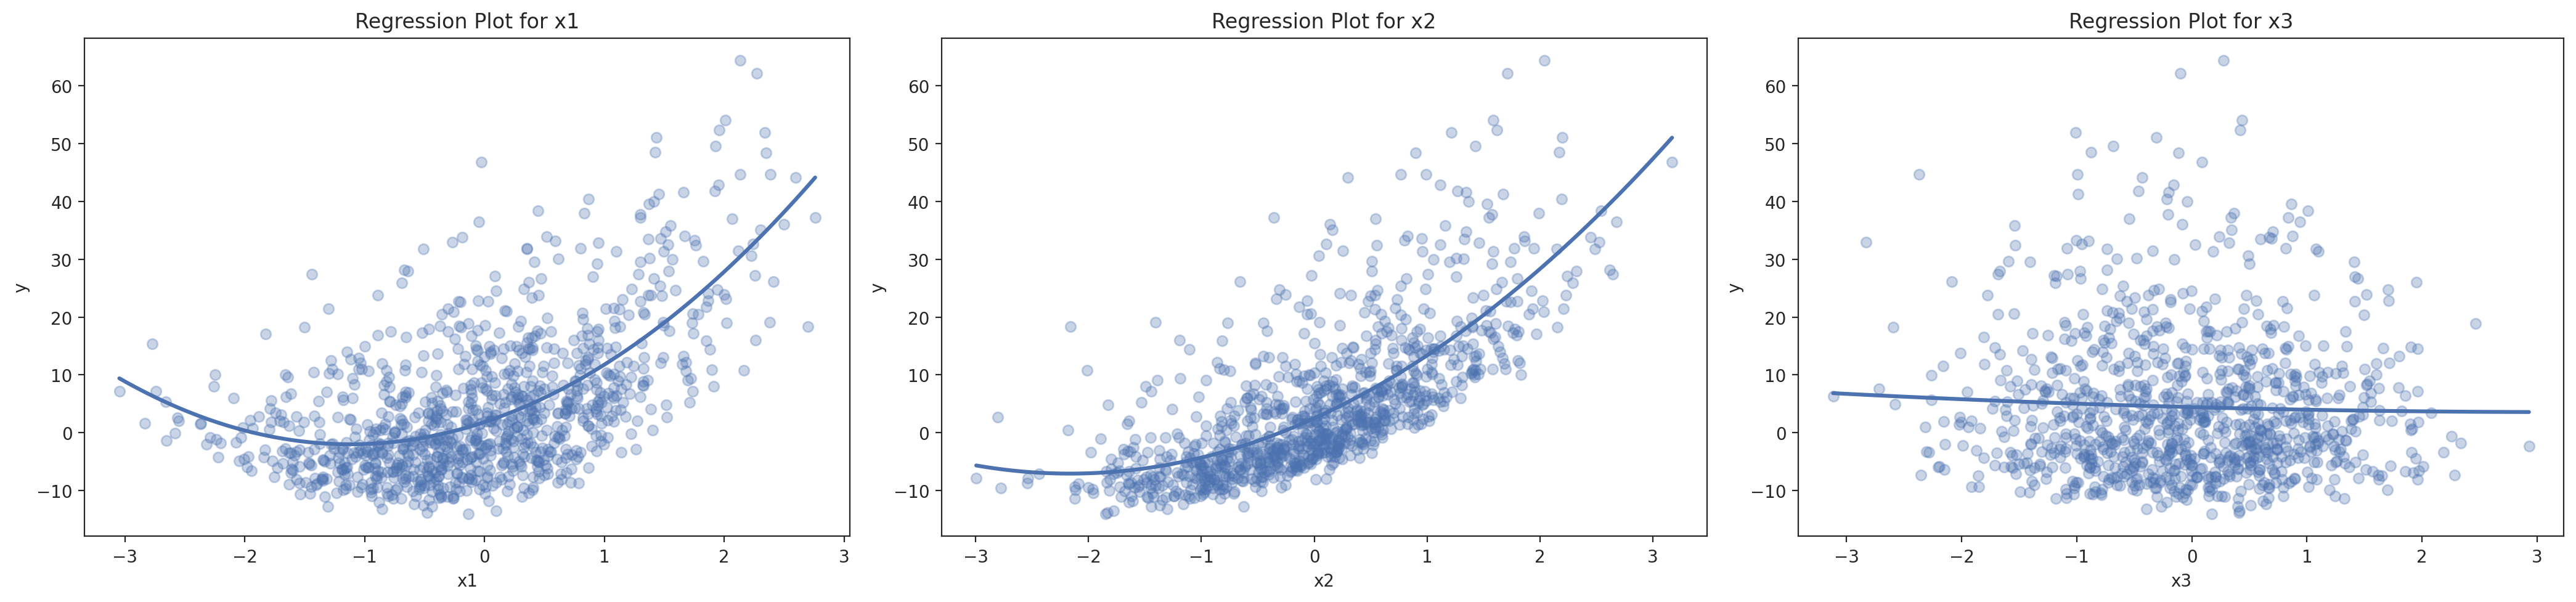

In [13]:
# Create subplots for each feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))

# Iterate over each feature and create a regression plot
for i, feature in enumerate(["x1", "x2", "x3"]):
    sns.regplot(data=df, x=feature, y='y', order=2, scatter_kws=dict(alpha=0.3), ax=axes[i], ci=None)
    axes[i].set_title(f'Regression Plot for {feature}')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


##The Linear Models##

In [16]:
# Create Features Matrix and Target Vector
X, y = df.drop(columns='y'), df['y']

In [15]:
# instantiate normal linear regression
normal_reg = Pipeline(
    steps=[
        ('lr', LinearRegression())
    ]
)

In [17]:
normal_reg.fit(X, y)

Pipeline(steps=[('lr', LinearRegression())])

**Evaluate Model Performance for the Normal Linear Regression**

In [18]:
# Coarse Grain Performance
eval_results = cross_validate(
    normal_reg, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [20]:
# Test Score Mean and STD
-eval_results['test_score'].mean(), eval_results['test_score'].std()

(4.09324988891751, 0.18810342806467575)

In [21]:
# Training Score Mean and STD
-eval_results['train_score'].mean(), eval_results['train_score'].std()

(4.045536339982105, 0.053764157606065344)

In [22]:
# Coefficent of model
normal_reg['lr'].coef_

array([ 6.96637705,  9.22817564, -0.2610917 ])

In [33]:
X.columns

Index(['x1', 'x2', 'x3'], dtype='object')

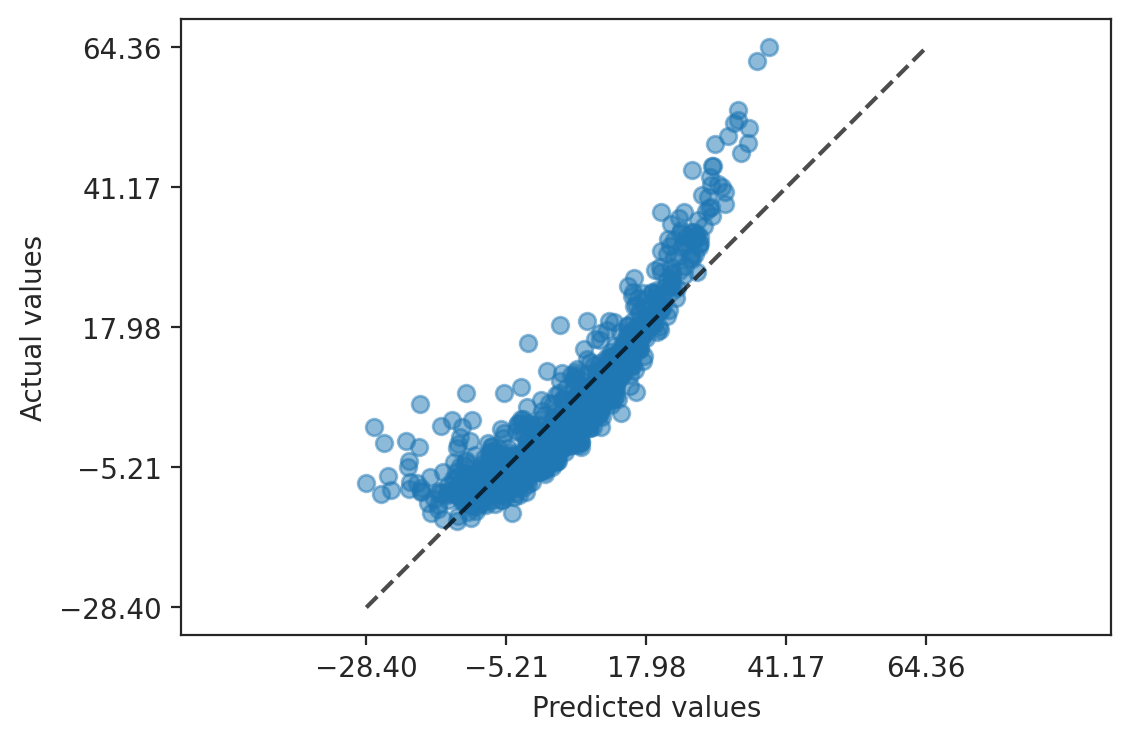

In [23]:
# Fine Grain Evaluation - Actual Vs Prediction
from sklearn.metrics import PredictionErrorDisplay

PredictionErrorDisplay.from_estimator(
    normal_reg, X, y, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
);

**Model with Polynomial Features Engineering**


In [25]:
# Instantiate the model
poly_reg = Pipeline(
    steps=[
        ('poly', PolynomialFeatures(2, include_bias=False)),
        ('plr', LinearRegression())
    ]
)

In [26]:
# Fit model
poly_reg.fit(X, y)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('plr', LinearRegression())])

In [27]:
# Coarse Grain Performance Evaluation
poly_eval_results = cross_validate(
    poly_reg, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [29]:
# Test Score Mean and STD
-poly_eval_results['test_score'].mean(), poly_eval_results['test_score'].std()

(1.6232407673368332, 0.02158742030538726)

In [30]:
# Training Score Mean and STD
-poly_eval_results['train_score'].mean(), poly_eval_results['train_score'].std()

(1.6110347145711514, 0.005857531181793634)

In [31]:
# Coefficients of model
poly_reg['plr'].coef_

array([ 7.02596189e+00,  9.02577412e+00,  3.98918724e-02,  3.02326703e+00,
        2.01847626e+00,  2.75527208e-02,  2.01428278e+00, -1.36853523e-01,
        2.98739128e-03])

In [34]:
# Get Variables of Model
poly_reg['poly'].get_feature_names_out()

array(['x1', 'x2', 'x3', 'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3',
       'x3^2'], dtype=object)

In [36]:
pd.DataFrame(
    dict(
        feat=poly_reg['poly'].get_feature_names_out(),
        coef=poly_reg['plr'].coef_
    ),
)

,feat,coef
0,x1,7.025962
1,x2,9.025774
2,x3,0.039892
3,x1^2,3.023267
4,x1 x2,2.018476
5,x1 x3,0.027553
6,x2^2,2.014283
7,x2 x3,-0.136854
8,x3^2,0.002987


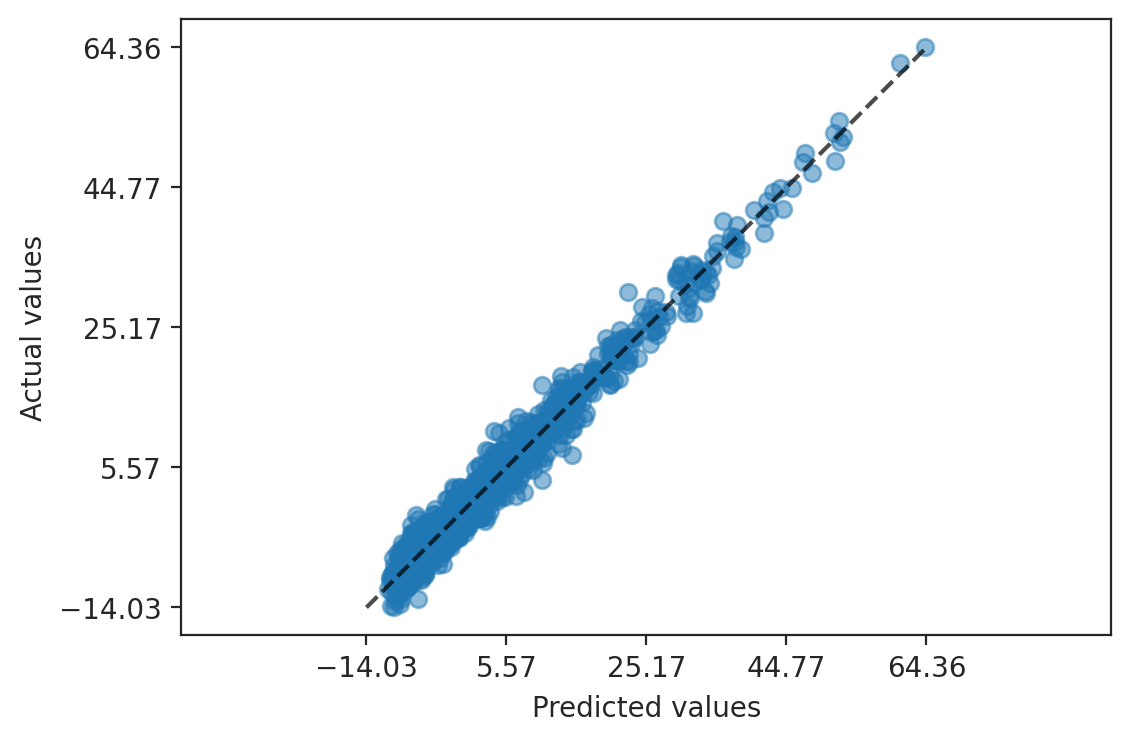

In [37]:
# Fine Grain Evaluation
PredictionErrorDisplay.from_estimator(
    poly_reg, X, y, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
);

##What is the Data Generation Procedure

In [38]:
n = 1000
np.random.seed(0)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)  # non informative feature
y = 3*(x1**2) + 2*x1*x2 + 2*(x2**2) + 7*(x1) + 9*(x2) + np.random.normal(0, 2, n)
# Non-linear and interaction terms